## Packages

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dat
import pickle
import re
from statistics import mode
# from pathlib import Path

# from google.colab import data_table
# data_table.enable_dataframe_formatter()

# preprocessing tool
import sklearn
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# modeling tool
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Classification models
from sklearn.cluster import KMeans 
from sklearn.ensemble import RandomForestClassifier

# novelty detection models
from sklearn.svm import OneClassSVM
from  sklearn.ensemble import IsolationForest
from  sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope


from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# font1 = {'family':'serif','color':'blue','size':30}
# font2 = {'family':'serif','color':'darkred','size':30}
# font2 = {'family':'serif','color':'red','size':30}

## Helper Functions
To extract flow metrics from traffic flow data and for the modeling

In [286]:
# PREPROCESSING
def extract_tcp_flag(n):
    '''
    to extract TCP flag from the info column
    '''
    pattern = r"\d\[\w*\W*\w*]|\W\[\w*\W*\w*]"
    pattern2 = r"[A-Z]{3}"
    a = ''.join(re.split("\s", n))
    b = re.findall(pattern, a)
    p = re.findall(pattern2, b[0]) if b else ''
    p = ''.join([f[0] for f in p])
    return p

def get_tcp_flag(n):
    '''
    used to extract TCP flag from the "TCP Flags" column
    '''
    return ''.join(re.findall("[a-zA-Z]", n)) 

def difference_fist_last(x):
    return x.iloc[-1] - x.iloc[0]

def scale_data (data, scaler):       
    scaled_X = scaler.transform(data) 
    return pd.DataFrame(scaled_X, columns=data.columns)

def strip_seconds (time):
    'return the seconds and microseconds part of a timedelta object as a float (sec.microseconds)'
    return round(float(str(time).split()[2].split(':')[2]),5)

def  calc_diff (item):
  "reyurn as list, the calculate the differences between two consecutive numbers in a list"
  diff = item.rolling(window=2).apply(difference_fist_last)
  return diff

# def calc_time_diff (timer):
#   "this calculate the differences between two consecutive values in a \
#   list of timeDelta object"
#   time_diff = [0.00]
#   _ = [time_diff.append(round(float(str(b - a).split()[2].split(':')[2]),2)) 
#        for a, b in zip(timer, timer[1:])]
#   return time_diff

    
# MODEL EVALUATION
def print_model_eval (y_true, y_pred):    
    accuracy = sklearn.metrics.accuracy_score
    b_accuracy = sklearn.metrics.balanced_accuracy_score
    print('='*50)
    print('Accuracy: ', accuracy(y_true, y_pred))  
    print('Balance Accuracy: ', b_accuracy(y_true, y_pred))
    print('='*50)

# VISUALIZATION
def get_pca (df, scale=True): 
    pca = sklearn.decomposition.PCA(n_components=2)
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)]) if scale else Pipeline([('pca', pca)])
    pca_df = pipe.fit_transform(df)
    print('PCA explained variance ratio:', pca.explained_variance_ratio_)
    return pca_df
                     
# Predicted label visualisation
def plot_pred_label (pca_data, y_pred, title = 'using label encoding'):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_pred, alpha=None, 
                    palette= "tab10"
                   )
    plot.set(title = f"Predicted label visualisation ({title})")
    plt.show() 

# True label visualisation
def plot_true_label (pca_data, y_true, title = 'one-hot'):
    plot = sns.scatterplot(x = pca_data[:,0], y = pca_data[:,1], 
                    hue=y_true, alpha=None, 
                    palette= "tab10"
                   )
    plot.set(title = f"True label visualisation ({title})")
    plt.show()

# MAKE FLOW DATA
def extract_flow_metrics(rolling_df, flow_dt): 
    'for extracting flow metric from traffic data and return it as a dictionary' 
    # transform the data
    rolling_df = rolling_df.replace(np.nan, '')   # to avoid the error presented by 'NaN'
    
    # TCP Flag variation
    try: 
        TCP_flags = list(map(get_tcp_flag, rolling_df['TCP Flags'])) 
    except:
        TCP_flags = list(map(extract_tcp_flag, rolling_df.Info)) 

    flow_dt['count_tcp_flags'].append(len(set(TCP_flags)))
    flow_dt['count_syn_flag'].append(''.join(TCP_flags).count('S'))
    flow_dt['count_ack_flag'].append(''.join(TCP_flags).count('A'))
    flow_dt['count_fin_flag'].append(''.join(TCP_flags).count('F'))
    flow_dt['count_rst_flag'].append(''.join(TCP_flags).count('R'))
    flow_dt['count_psh_flag'].append(''.join(TCP_flags).count('P'))

    # protocol variation
    flow_dt['count_icmp'].append(rolling_df.Protocol.tolist().count('ICMP'))
    flow_dt['count_udp'].append(rolling_df.Protocol.tolist().count('UDP'))
    flow_dt['count_tcp'].append(rolling_df.Protocol.tolist().count('TCP'))  
    flow_dt['count_tls'].append(rolling_df.Protocol.tolist().count('TLSv1.2'))   # track presense of encrypted packets
    flow_dt['count_ntp'].append(rolling_df.Protocol.tolist().count('NTP'))  
    flow_dt['count_dns'].append(rolling_df.Protocol.tolist().count('DNS'))  
    flow_dt['no_unique_prot'].append(len(rolling_df.Protocol.unique()))
    
    flow_dt['ave_pack_IAT'].append(calc_diff(rolling_df.time_ff).mean())
    flow_dt['flow_dur'].append(difference_fist_last(rolling_df.time_ff))

    flow_dt['no_unique_pl'].append(len(rolling_df.Length.unique()))
    if mode(rolling_df["Sequence Number"]) == '':
        flow_dt['sn_type'].append(-1) 
    elif mode(rolling_df["Sequence Number"]) > 0:
        flow_dt['sn_type'].append(1) 
    else:
        flow_dt['sn_type'].append(-1)

    #==========================================
    # # TCP packet lenght variation
    # flow_dt['av_pl'].append(rolling_df.Length.mean())         
    # flow_dt['tcp_pl'].append(len(set(rolling_df.query("Protocol=='TLSv1.2'").Length)))      

    # # sequence no variation
    # try: 
    #     flow_dt['av_sn'].append(np.mean([float(item) for item in rolling_df["Sequence number"]]))
    # except:
    #     flow_dt['av_sn'].append(-1)   

    # 
    # packet interarrival time and flow duration
#     try: 
#         flow_dt['ave_pack_IAT'].append(np.mean(calc_time_diff(rolling_df.Time)))
#     except:
#         flow_dt['ave_pack_IAT'].append(np.mean(calc_diff(rolling_df.Time)))


# # _ = [time_diff.append(round(float(str(b - a).split()[2].split(':')[2]),2)) 
# #         for a, b in zip(timer, timer[1:])]
#     # flow volume
#     # flow_dt['flow_volume'].append(len(rolling_df)) # to be used if rolling by time
    return flow_dt 

def make_training_data(df, device_ipadd, attack_ipadd= None, roller=47, step=2):
    '''
    Group specified numbers of packets together, extract flow metric and make the flow data
    for training the model
    '''  
    # Verify that the required columns are present and correctly named
    required_col = ['Time since reference or first frame', 'Source', 'Destination', 'Protocol', 'Length', 'Sequence Number', 'Info']
    assert all([i in df.columns.tolist() for i in required_col]), f"The following columns are required: {[i for i in required_col if i not in list(df.columns)]}"
    
    flow_dt = {'pkt_start':[], 'pkt_end':[], 'flow_dur':[], 'ave_pack_IAT':[],'count_tcp_flags':[], 
                'count_syn_flag':[], 'count_ack_flag':[], 'count_fin_flag':[], 'count_rst_flag':[], 'count_psh_flag':[], 
                'count_tcp':[], 'count_tls':[],'count_icmp':[], 'count_udp':[],  'count_ntp':[], 'count_dns':[], 
                'no_unique_prot':[], 'no_unique_pl':[], 'sn_type':[]
            }
    
    df.rename(columns = {'Time since reference or first frame':'time_ff'}, inplace=True) #to conveniently use the column name

    # if device_ipadd: data = df.query(f'Source == "{device_ipadd}" | Destination == "{device_ipadd}"')  # to filter out background noise
    if attack_ipadd == None:
        df = df.query(f'Destination == "{device_ipadd}"').reset_index(drop=True)  # to filter out background noise
    else:
        df = df.query(f'Source == "{attack_ipadd}" & Destination == "{device_ipadd}"').reset_index(drop=True)  # to filter out background noise
    assert  len(df) > 0, 'Confirm that the correct device IP address is provided. All the traffic count been filtered out as background noise.'
    # print(df) # for debugging

    flow_id = 1
    start = 0
    roller = roller
    step = step
    print('Sliding Window set at', 1+roller+step)

    for r in range(0, len(df), step):                               
        if (r+roller > len(df)): 
    #         print (start, ':', len(df))
            flow_dt['pkt_start'].append(start)
            flow_dt['pkt_end'].append(len(df))
            rolling_df = df[start:end]
        else :
            if r == 0:
                continue 
            else:
                end = r+roller
    #             print(start, ':', r+roller)
                rolling_df = df[start:end]
                flow_dt['pkt_start'].append(start)
                flow_dt['pkt_end'].append(end)
                
        flow_dict = extract_flow_metrics(rolling_df, flow_dt)
        start = r
        flow_id+= 1
    print('Done extracting flow data')
    return pd.DataFrame.from_dict(flow_dict).iloc[:,0:]

def make_modeling_data(datalist, device_ipadd, attack_ipadd, save_to_csv=True, df_name='', roller=2, step=2):
    '''
    Extract flow data from series of traffic data and combine all the data together to make a single data for trainig or testing our model
    '''
    all_flow_dt = pd.DataFrame()
    for d in datalist:
        if d.name.unique()[0] == 'Normal': 
            flow_data = make_training_data(d, device_ipadd="192.168.0.101", roller=roller, step=step)
        else:
            flow_data = make_training_data(d, device_ipadd, attack_ipadd, roller=roller, step=step)
        flow_data['label'] = d.name.unique()[0]
    #     flow_data.to_csv(f'{d.name.values[0]}_flow.csv')
        all_flow_dt=pd.concat([all_flow_dt, flow_data], ignore_index=True)
        print(f'Done with {d.name.unique()[0]}')    
    print('Done with all the data')
    if save_to_csv: all_flow_dt.to_csv(f'../data/Training_data/{df_name}_v1.0.csv')
    return all_flow_dt

## Modeling

#### Extract flow data and make the training data

In [ ]:
# read all data
from helpers import read_multifiles
train = read_multifiles(basepath = '../data/large_data/data_2509/train', datalist = [], pickle_file=False)
# [print(n.name[0]) for n in train]   # view the arrangement of the files

normal_hive_ipaddr = "192.168.0.101"
device_ipadd = "192.168.0.102"
attack_ipadd = "192.168.0.103"
# training_df = make_modeling_data(train, device_ipadd, df_name='Train', roller=7, step=2, save_to_csv=False)
# # or 
# training_df = pd.read_csv(f'../data/Training_data/train_1.0.csv')

# training_df

### EDA

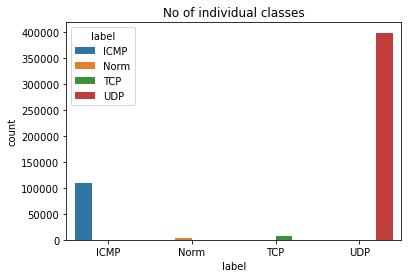

,flow_dur,pkt_start,pkt_end,no_tcp_flags,has_syn_flag,has_ack_flag,has_fin_flag,has_rst_flag,has_psh_flag,count_icmp,...,count_tcp,count_tlsv,count_ntp,count_dns,no_unique_prot,average_pack_time,av_pl,tcp_pl,av_sn,label
0,0,0,9,5,0,7,1,3,3,0,...,6,3,0,0,2,0.024444,325.555556,3,-1,ICMP
1,0,2,11,6,0,6,1,3,2,0,...,6,2,0,1,3,0.061111,269.888889,3,-1,ICMP
2,0,4,13,6,1,4,0,3,1,0,...,6,1,0,2,3,0.063333,273.111111,4,-1,ICMP
3,0,6,15,6,2,5,0,1,1,0,...,6,1,0,2,3,0.063333,274.666667,4,-1,ICMP
4,0,8,17,5,2,6,0,0,2,0,...,5,2,0,2,3,0.073333,163.222222,2,-1,ICMP
5,0,10,19,5,2,6,0,0,2,0,...,5,2,0,2,3,0.015556,291.888889,3,-1,ICMP
6,0,12,21,4,2,8,0,0,3,0,...,7,2,0,0,2,0.013333,592.777778,3,-1,ICMP
7,0,14,23,2,0,9,0,0,5,0,...,5,4,0,0,2,0.011111,719.444444,2,-1,ICMP
8,0,16,25,2,0,9,0,0,5,0,...,5,4,0,0,2,0.000000,672.555556,2,-1,ICMP
9,0,18,27,2,0,9,0,0,4,0,...,6,3,0,0,2,0.000000,661.444444,2,-1,ICMP


In [11]:
#1 read in flow data 
# flow_data = pd.read_csv('../data/Training_data/Training_data_23_09_w5.csv').iloc[:,1:]
training_df = pd.read_csv('../data/Training_data/train_data_27_09_w5.csv').iloc[:,1:]
flow_data =  training_df.copy()
flow_data.label = flow_data.label.apply(lambda x: x[:-2])

# EDA
plot = sns.countplot(x= 'label', data = flow_data,
                    hue='label', palette= "tab10"
                   )
plot.set(title = "No of individual classes")
plt.show()

flow_data.head(10)

### Train Random Forest

Accuracy:  0.9967690545805848
Balance Accuracy:  0.9832684148900267
PCA explained variance ratio: [0.38510124 0.12338883]


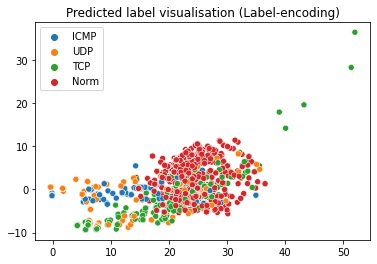

In [12]:
def make_attack_model (flow_data, scale=False, plot_eval=True):
    #2 Preprocess data
    y = flow_data['label']
    X = flow_data.drop(columns = ['pkt_start','pkt_end', 'label'])  # drop dummy column and the actual label 
    X['av_sn'].replace([np.nan], -1, inplace=True)   # encode flows with no average sequece number (nan) with -1

    #3 create scaler and scale the data
    scaler = StandardScaler().fit(X)  
    if scale: 
        X = scale_data(X, scaler)

    #4 modeling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10, shuffle=True, stratify=y)
    model = RandomForestClassifier(random_state=10).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #5 evaluate model
    print_model_eval(y_test, y_pred)
    if plot_eval:
        # visualiozation
        pca_le = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
        plot_pred_label (pca_le, y_pred, title = 'Label-encoding') # predicted label
        # plot_true_label(pca_le, y_test, 'Label-encoding')  # true label
        
    return model, scaler

model, scaler = make_attack_model(flow_data, scale=True) # for use during prediction 

# save model and scaler 
pickle.dump(scaler, open('../models/scaler_29_09', 'wb'))  
pickle.dump(model, open('../models/RF_model_29_09', 'wb')) 

### Novelty Detection

PCA explained variance ratio: [0.2132168  0.17338221]


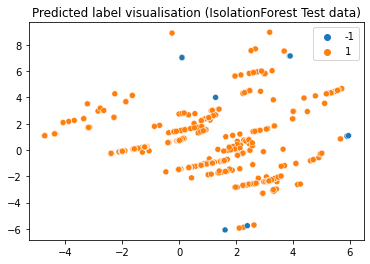

IsolationForest ===> no of test set - 1923 : no of novel data - 15
==================== ICMPprivate ====================
PCA explained variance ratio: [1.0000000e+00 7.7330743e-26]


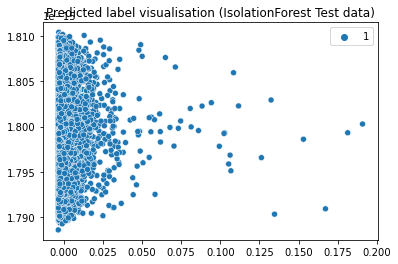

IsolationForest ===> no of test set - 15964 : no of novel data - 0
==================== TCPSYNprivate ====================
PCA explained variance ratio: [0.99652027 0.00263258]


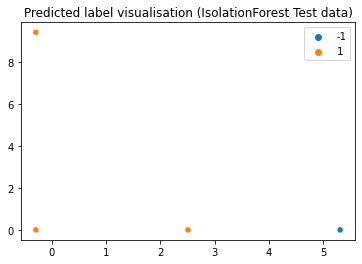

IsolationForest ===> no of test set - 44039 : no of novel data - 33
==================== UDPprivate ====================
PCA explained variance ratio: [9.99376590e-01 6.23409785e-04]


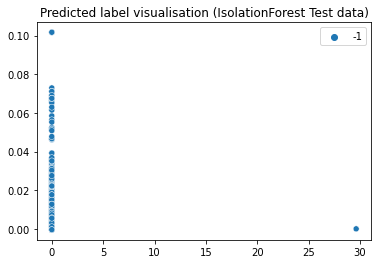

IsolationForest ===> no of test set - 156874 : no of novel data - 156874
==================== benignprivate ====================
PCA explained variance ratio: [0.22285007 0.17375706]


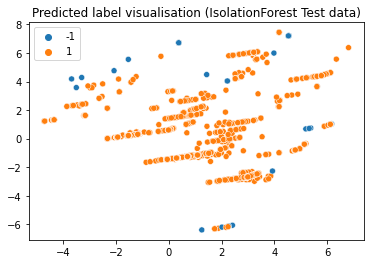

IsolationForest ===> no of test set - 4758 : no of novel data - 43
PCA explained variance ratio: [0.78894274 0.0501044 ]


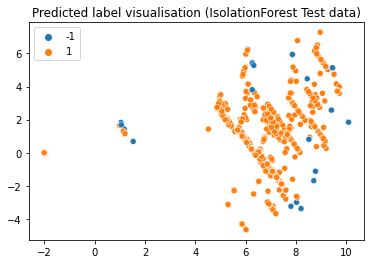

IsolationForest ===> no of test set - 20722 : no of novel data - 44


In [7]:
def make_novelty_model (flow_data, model=None, modelname='IsolationForest', scaler=None, scale=True, plot_eval=True, 
                        test_size=0.3, train_model=True):
    'If train_model is set to `False`, you must supply already fitted `model` and `scaler`\
    '
    #2 Preprocess data
    y = flow_data['label']
    X = flow_data.drop(columns = ['pkt_start','pkt_end', 'label'])  # drop dummy column and the actual label 
    X['av_sn'].replace([np.nan], -1, inplace=True)   # encode flows with no average sequece number (nan) with -1

    #3 create scaler and scale the data
    if train_model: scaler = StandardScaler().fit(X)  
    if scale: 
        X = scale_data(X, scaler)

    #4 split out test set (use all is already trained model is supplied i.e train_model=False)
    if train_model:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10, shuffle=True)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.99, random_state=10, shuffle=True)


    #4 modeling
    if train_model: 
        model = IsolationForest(max_samples='auto', contamination=0.01, 
                                random_state=1, n_estimators=100).fit(X_train, y_train)
    # X_Train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    #5 evaluate model
    # print_model_eval(y_test, y_pred)

    #6 visualization
    if plot_eval:
        pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
        plot_pred_label (pca_test, y_pred, title = f'{modelname} Test data') # predicted label

        # pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
        # plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
        
    index = np.where(y_pred==-1)[0]
    print(modelname, '===>', 'no of test set -', len(X_test), ':', 'no of novel data -', len(X_test.iloc[index]))

    if train_model: return model, scaler

flow_dt = flow_data.query("label == 'benignprivate'")
model, scaler = make_novelty_model (flow_dt, test_size=0.4)

# save model and scaler 
# pickle.dump(scaler, open('../models/novelty_scaler', 'wb'))  
# pickle.dump(model, open('../models/novelty_model', 'wb')) 

# predict on all atack flow
attack_labels = ['ICMPprivate', 'TCPSYNprivate', 'UDPprivate', 'benignprivate']
for l in attack_labels:
    # flow_dt = flow_data.query(f"label == '{attack_labels[1]}'")
    print ('='*20, l, '='*20)
    flow_dt = flow_data.query(f"label == '{l}'")
    make_novelty_model (flow_dt, model=model, scaler=scaler, plot_eval=True, train_model=False)

# trial codes for combined data
attack_labels = ['ICMPprivate', 'TCPSYNprivate', 'UDPprivate', 'benignprivate']
flow_dt = flow_data.query(f"label == '{attack_labels[0]}' | label == '{attack_labels[3]}'")
make_novelty_model (flow_dt, model=model, scaler=scaler, plot_eval=True, train_model=False)

test data (Normal)

==================

OneClassSVM ===> 1442 : 37                          OneClassSVM ===> 3365 : 132

LOF ===> 1442 : 61                                  LOF ===> 3365 : 118

EllipticEnvelope ===> 1442 : 44                     EllipticEnvelope ===> 3365 : 111

IsolationForest ===> 1442 : 9                       IsolationForest ===> 3365 : 25


Almost ALL 'ICMPprivate' and 'TCPSYNprivate' detected as Normal flow

Almost ALL 'UDPprivate' detected as Normal flow


## Detection

In [117]:
def attack_detector (df, device_ipadd, trained_model, scaler, attack_ipadd = None, roller = 47, step = 2):
    f'''
    Predict if a tuple of {roller + step + 1} packets is an attack or normal flow by extracting
    flow metric from the {roller + step + 1} packet tuple and using the loaded model for the predict.
    '''
    
    if attack_ipadd == None:
        data = df.query(f'Destination == "{device_ipadd}"').reset_index(drop=True)  # to filter out background noise
    else:
        data = df.query(f'Source == "{attack_ipadd}" & Destination == "{device_ipadd}"').reset_index(drop=True)  # to filter out background noise

    assert  len(data) > 0, 'Confirm that the correct device IP address is provided. All the traffic count been filtered out as background noise.'
    # print(data) # for debugging
    
#1  Extract flow data ------->flow_df = make_flow_data(traffic_df)
    flow_id = 1
    start = 0
    atk_name = []
    atk_str  = []
    atk_end = []
    atk_mode = []
    for r in range(0, len(data), step):        
        flow_dt = {'pkt_start':[], 'pkt_end':[], 'count_tcp_flags':[],  'ave_pack_IAT':[],
                'count_syn_flag':[], 'count_ack_flag':[], 'count_fin_flag':[], 'count_rst_flag':[], 
                'count_psh_flag':[], 'count_icmp':[], 'count_udp':[], 'count_tcp':[],
                'count_tls':[], 'count_ntp':[], 'count_dns':[], 'no_unique_prot':[],       
                'flow_dur':[], 'no_unique_pl':[], 'sn_type':[]
            }
        
        # get chunk of traffic packets (based on the defined window (roller+step+1))
        if (r+roller > len(data)): 
            flow_dt['pkt_start'].append(start)
            flow_dt['pkt_end'].append(len(data))
            rolling_df = data[start:end]
        else :
            if r == 0:
                continue 
            else:
                end = r+roller
                # print(start, ':', r+roller)
                rolling_df = data[start:end]
                flow_dt['pkt_start'].append(start)
                flow_dt['pkt_end'].append(end)
        # print(rolling_df) # for debugging

        # extract flow metrics from the chunk of traffic packets  
        flow_dict = extract_flow_metrics(rolling_df, flow_dt)
        
        # convert the flow metrics data into a dataframe
        flow_dt = pd.DataFrame.from_dict(flow_dict) 
        # print('='*10, f'flow {flow_id} : packet {start} -- packet {end}', '='*10)  # for debugging purpose
        # print(flow_dt) # for debugging purpose

#2      Preprocess the flow data
        feature = flow_dt.drop(columns = ['pkt_start','pkt_end'])  # drop dummy column and the actual label 
        # feature['av_sn'].replace([np.nan], -1, inplace=True)   # encode flows with no average sequece number (nan) with -1
        
#3      scale the flow data
        feature = scale_data(feature, scaler)
            
        packet_info = flow_dt.loc[:,['pkt_start','pkt_end']]
#         print('='*50, )    ##for debugging purpose
#         print(feature)     ##for debugging purpose

#5      make prediction
        pred = trained_model.predict(feature)[0]
        # print (pred)   ##for debugging purpose

#6      Take action based on the prediction (traffic flow type)
        if pred != 'Norm':
            print( f'"{pred}" Attack detected between packet: {packet_info.pkt_start[0]} and {packet_info.pkt_end[0]} \n stop server NOW')
            atk_name.append(pred)                                                         # For monitoring or later analysis
            atk_str.append(packet_info.pkt_start[0])                                      # For monitoring or later analysis
            atk_end.append(packet_info.pkt_end[0])                                        # For monitoring or later analysis
                                                                                    
            try:                                                                      
                atk_mode.append(mode(rolling_df.Protocol))   # to guess the attack type for monitoring or later analysis
                # atk_mode.append(rolling_df.Protocol.mode().values[0])   # to guess the attack type for monitoring or later analysis
            except:                                                                     
                atk_mode.append('unknown')                   # For monitoring or later analysis
            print (pred)   ## for debugging purpose
            break    # uncomment if you need to stop detection after first attack has been detected
        # else:                                                                        # For monitoring 
        #     print('"Normal flow"')                                                     
        # print('='*50, f'flow {flow_id} : start {end}', '='*50)  
        start = r
        flow_id+= 1
    return atk_name, atk_str, atk_end, atk_mode

Sliding Window is  10
Done with ICMP03
Sliding Window is  10
Done with Normal
Done with all the data
PCA explained variance ratio: [0.50772629 0.11648692]


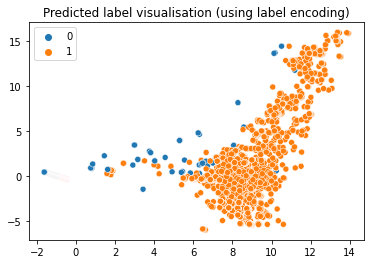

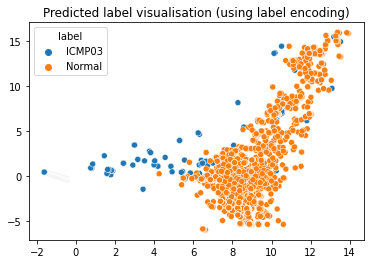

In [71]:
training_df = training_df = make_modeling_data(train[:2], device_ipadd, name='Train', roller=7, step=2, save_to_csv=False)
n = len(traffic_df)
y_p = KMeans(n_clusters=2).fit_predict(training_df.iloc[:n,:-1])

pca_d = get_pca(training_df.iloc[:n,:-1])
plot_pred_label (pca_d, y_p, title = 'using label encoding')
plot_pred_label (pca_d, training_df.iloc[:n,-1], title = 'using label encoding')

# training_df.iloc[:10000,-1]

In [63]:
[print(np.unique(test[i].name)) for i in range(len(test))]
set(training_df.copy().label)


['ICMP01']
['ICMP02']
['TCP03']
['TCP04']
['UDP04']
['UDP05']


{'ICMP03',
 'ICMP04',
 'ICMP05',
 'Normal',
 'TCP01',
 'TCP02',
 'TCP05',
 'UDP01',
 'UDP02',
 'UDP03'}

### testing data

In [10]:
# device_ipadd = "192.168.0.102"
test = read_multifiles(basepath = '../data/large_data/data_2509/test', datalist = [], pickle_file=False)
# test_df = make_modeling_data(test, device_ipadd, name='Test')

processing: ICMP01.csv
processing: ICMP02.csv
processing: TCP03.csv
processing: TCP04.csv
processing: UDP04.csv
processing: UDP05.csv
All files have now been loaded


In [15]:
# # use the trained model for continous monitoring
# trained_scaler = pickle.load(open('../models/scaler_24_09', 'rb')) 
# trained_model = pickle.load(open('../models/RF_model_24_09', 'rb'))
trained_scaler = scaler
trained_model = model

# Read the data (detection - get traffic data)
for i in range(len(test)):
    traffic_df = test[i].copy()
    device_ipadd = "192.168.0.102"
    print(set(traffic_df.name))
    atk_n, atk_s, atk_e, atk_m =  attack_detector(traffic_df, device_ipadd, trained_model, scaler=trained_scaler, roller = 47)

{'ICMP01'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'ICMP02'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'TCP03'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'TCP04'}
"TCP" Attack detected between packet: 0 and 49 
 stop server NOW
TCP
{'UDP04'}
"TCP" Attack detected between packet: 2 and 51 
 stop server NOW
TCP
{'UDP05'}
"TCP" Attack detected between packet: 4 and 53 
 stop server NOW
TCP


#### Detection result (RF) 3x2 dataset

NORMAL: no attack     ----> all normal

ICMP: attack starts from packet no 58       ----> "ICMPprivate" Attack detected between packet: 56 and 60

UDP: attack starts from packet no 262       ----> "UDPprivate" Attack detected between packet: 260 and 264

_TCPSYN: attack starts from packet no 0      ----> 'TCPSYN' attack detected between parket: 0 and 4

NORMAL (Public): no attack      ----> "ICMPprivate" Attack detected between packet: 4 and 8

# Others

## Usefull codes

In [ ]:
# d = filtered_tcpsyn_df[:100]
# make_training_data(d, roller=2, step=2)

# if 'TCP Flags' in rolling_df.columns: print(' TCP Flags column present')


PCA explained variance ratio: [0.28581791 0.14742411]


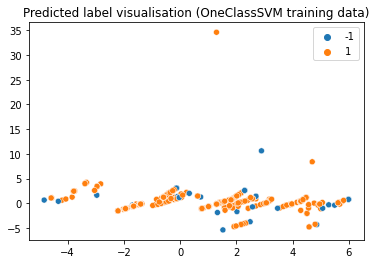

PCA explained variance ratio: [0.2693828  0.12944426]


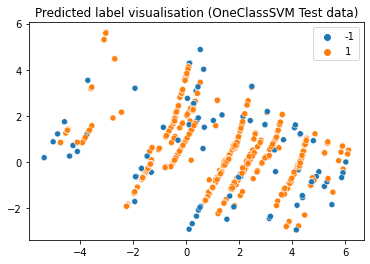

OneClassSVM ===> 3365 : 132


c:\Users\OMApe\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
c:\Users\OMApe\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


PCA explained variance ratio: [0.28581791 0.14742411]


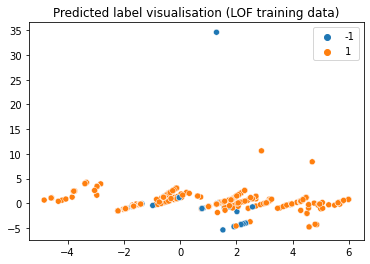

PCA explained variance ratio: [0.2693828  0.12944426]


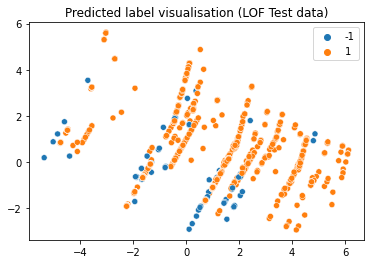

LOF ===> 3365 : 118


c:\Users\OMApe\anaconda3\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


PCA explained variance ratio: [0.28581791 0.14742411]


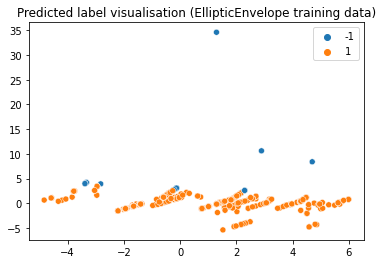

PCA explained variance ratio: [0.2693828  0.12944426]


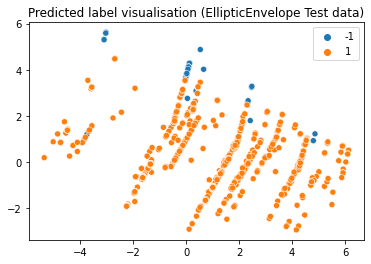

EllipticEnvelope ===> 3365 : 111


In [ ]:
# #4 modeling (OneClassSVM)
# modelname = 'OneClassSVM'
# # model = OneClassSVM(kernel='rbf', gamma=0.05, nu=0.05).fit(X_train)
# model = OneClassSVM(kernel='rbf', degree=3, gamma='scale', nu=0.005).fit(X_train)
# X_Train_pred = model.predict(X_train)
# X_Test_pred = model.predict(X_test)

# #5 evaluate model
# if plot_eval:
#     # visualiozation
#     pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
    
#     pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_test, X_Test_pred, title = f'{modelname} Test data') # predicted label
        
# index = np.where(X_Test_pred==-1)[0]
# print(modelname, '===>', len(X_test), ':', len(X_test.iloc[index]))
# print('='*50)

# #4 modeling (LoF)
# modelname = 'LOF'
# model = LocalOutlierFactor(n_neighbors=20, algorithm='auto',
#                          metric='minkowski', contamination=0.04,
#                          novelty=True, n_jobs=-1)
# model = model.fit(X_train)
# X_Train_pred = model.predict(X_train)
# X_Test_pred = model.predict(X_test)

# #5 evaluate model
# # print_model_eval(y_test, y_pred)
# if plot_eval:
#     # visualiozation
#     pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
    
#     pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_test, X_Test_pred, title = f'{modelname} Test data') # predicted label

# index = np.where(X_Test_pred==-1)[0]
# print(modelname, '===>', len(X_test), ':', len(X_test.iloc[index]))
# print('='*50)

# # modeling (EllipticEnvelope)
# modelname = 'EllipticEnvelope'
# model = EllipticEnvelope(contamination=0.025, random_state=1)
# model = model.fit(X_train)
# X_Train_pred = model.predict(X_train)
# X_Test_pred = model.predict(X_test)
# # y_pred = model.predict(X_test)

# #5 evaluate model
# # print_model_eval(y_test, y_pred)
# if plot_eval:
#     # visualiozation
#     pca_train = get_pca(X_train, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_train, X_Train_pred, title = f'{modelname} training data') # predicted label
    
#     pca_test = get_pca(X_test, scale=False) if scale else get_pca(X_test) # PCA
#     plot_pred_label (pca_test, X_Test_pred, title = f'{modelname} Test data') # predicted label

# index = np.where(X_Test_pred==-1)[0]
# print(modelname, '===>', len(X_test), ':', len(X_test.iloc[index]))
# print('='*50)
